In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer


import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/epileptic/Epileptic_Seizure_Recognition.csv")
data = data.drop(columns=['Unnamed'])
data.loc[data["y"] > 1 , "y"] = 0
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data = data[:70000]

In [5]:
target = 'y'

In [6]:
X = data.drop(columns=[target])
y = data[target]

In [7]:
#model_ctgan = CTGANSynthesizer(epochs=20)
model_ctgan = DPCTGANSynthesizer(verbose=True)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data)

Init CTGAN with differential privacy.  Target epsilon: 3
Epoch 1, Loss G: -4.7543, Loss D: -2.2690, Epsilon: 2.8636
Epoch 2, Loss G: -3.9999, Loss D: -1.6392, Epsilon: 3.4245


In [8]:
from utils.utils import save_models
save_models(model_ctgan, 'dpctgan3', 'epileptic')

In [9]:
from utils.utils import load_models
model_ctgan = load_models('dpctgan3', 'epileptic')

In [10]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [11]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [12]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.06226404]


## Fidelity

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = True)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = True)

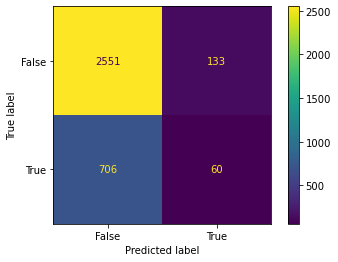

In [14]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [15]:
percentage, class1_ratio, class2_ratio = eval_fidelity(rr_pred, fr_pred)

In [16]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.9315942028985508
Accuracy of synthetic data:  0.7782608695652173


In [17]:
print(class1_ratio, class2_ratio)

0.7525073746312685 0.06674082313681869


## Final plot

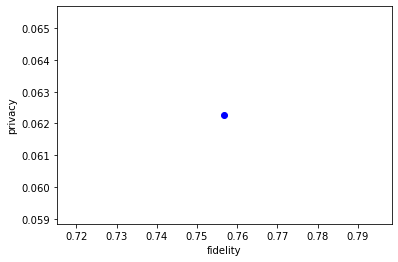

0.7568115942028986 [0.06226404]


In [18]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)